### Generalization 
- we want to discover patterns that generalize as ML scientiests
- we dont want to overfit to our training data. to combat we use regularization methods
- generlization error is error we would see if we were to apply our model to new data (assuming same distribution b/w training and test data)
- 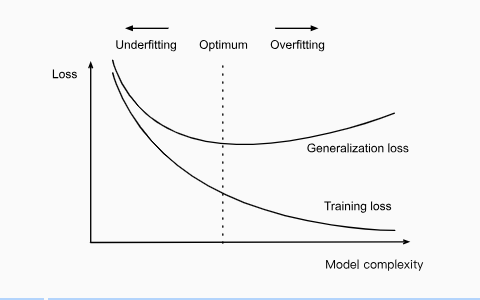
- in principle try not touch test data until we are ready to evaluate our model & all hyperparameters have been chosen. never rely on test data to for model selection
- split into 3 sets: training, validation, test. 
- Cross validation is technique. Good when we dont have much data. K-fold cross validation is most common. Subset training data into k subsets. Train on k-1 and validate on kth. Repeat k times. Average the results.


Rules of thumb:
1.Use validation sets (or fold cross-validation) for model selection;
2. More complex models often require more data;
3. Relevant notions of complexity include both the number of parameters and the range of values that they are allowed to take;
4. Keeping all else equal, more data almost always leads to better generalization;
5. This entire talk of generalization is all predicated on the **IID assumption**(train & test data follow same distribution). If we relax this assumption, allowing for distributions to shift between the train and testing periods, then we cannot say anything about generalization absent a further (perhaps milder) assumption.




### Weight Decay
- restrict the values the parameters can take.
- More commonly known as L2 regularization . Add the penalty term,  sum of the squares of the weights to the loss function. reduces complexity of learned network
- minimize sum of prediction loss and penalty/regularization term
- usually add a nonnegative hyperparameter lambda to control the amount of regularization
- l2 norm is ridge regression, l1 norm is lasso regression
- our optimization "decays" the weights towards zero
- 

In [17]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

In [18]:
class Data(d2l.DataModule):
    def __init__(self, num_train, num_val, num_inputs, batch_size):
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, num_inputs)
        noise = torch.randn(n, 1) * 0.01
        w, b = torch.ones((num_inputs, 1)) * 0.01, 0.05
        self.y = torch.matmul(self.X, w) + b + noise

    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.X, self.y], train, i)

In [3]:
def l2_penalty(w):
    return (w ** 2).sum() / 2

In [4]:
class WeightDecayScratch(d2l.LinearRegressionScratch):
    def __init__(self, num_inputs, lambd, lr, sigma=0.01):
        super().__init__(num_inputs, lr, sigma)
        self.save_hyperparameters()

    def loss(self, y_hat, y):
        return (super().loss(y_hat, y) +
                self.lambd * l2_penalty(self.w))

In [37]:
data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)
trainer = d2l.Trainer(max_epochs=10)

def train_scratch(lambd):
    model = WeightDecayScratch(num_inputs=200, lambd=lambd, lr=0.01)
    model.board.yscale='log'
    trainer.fit(model, data)
    print('L2 norm of w:', float(l2_penalty(model.w)))

L2 norm of w: 0.010900316759943962


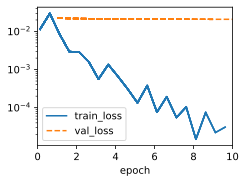

In [38]:
train_scratch(0) # weight decay off lambda = 0 ... overfitting bad!! trainloss better but val loss not

L2 norm of w: 0.0015167354140430689


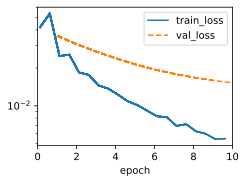

In [39]:
train_scratch(3)

In [40]:
class WeightDecay(d2l.LinearRegression):
    def __init__(self, wd, lr):
        super().__init__(lr)
        self.save_hyperparameters()
        self.wd = wd
# default pytorch decays both weights and bias.. but we can configure.. here only decay weight
    def configure_optimizers(self):
        return torch.optim.SGD([
            {'params': self.net.weight, 'weight_decay': self.wd},
            {'params': self.net.bias}], lr=self.lr)

L2 norm of w: 0.01275317370891571


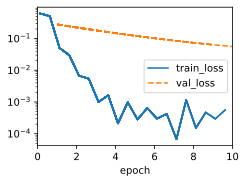

In [41]:
model = WeightDecay(wd=3, lr=0.01)
model.board.yscale='log'
trainer.fit(model, data)

print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))